We connect to google drive where the dataset has been stored


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


We import the libraries that we are going to use

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import keras
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.layers import Dropout, BatchNormalization, Activation
from keras.utils import plot_model
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix
import seaborn as sns
import cv2
from tqdm import tqdm
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import os

# Import Data

The datast used for this notebook is about the different memotions of the human face. This dataset has 8 classes and the names of this 8 classes has been saved in the labels variable to be used while importing the dataset.

In [3]:
labels = ['anger','contempt','disgust','fear','happy','neutral','sad','surprise']

The dataset consists of two folders. One folder for training and another one for tuning. So, with that in mind 4 variables are created. X_train for storing the images and y_train for storing the labels of the train folder. X_tune for storing the images and t_tune for storing the labels of the tune folder. The dataset was uploaded to the google drive. For imoprting the images cv2 is used. As mentioned earlier, the classes of the dataset are saved in the 'labels' variable, So with the help of that in the for loop we can go through each class in the TRAIN and TUNE folders and save the images in X_train and X_tune. The labels are saved in the y_train and y_tune acoarding to the folder that the images are imported from.

At the end, all the lists are converted to NumPy arrays, and X_train and X_tune are normalized by dividing the arrays by 255.

In [4]:
X_train = []
X_tune = []
y_train = []
y_tune = []

for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/Face_Emotion_Dataset','TRAIN',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        X_train.append(img)
        y_train.append(i)

for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/Face_Emotion_Dataset','TUNE',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        X_tune.append(img)
        y_tune.append(i)

X_train = np.array(X_train)
X_tune = np.array(X_tune)
y_train = np.array(y_train)
y_tune = np.array(y_tune)
X_train = X_train/255
X_tune = X_tune/255

100%|██████████| 200/200 [00:04<00:00, 44.50it/s] 


The shapes of X_train and X_tune are printed

In [5]:
X_train.shape

(8000, 128, 128, 3)

In [6]:
X_tune.shape

(1600, 128, 128, 3)

# Data split

Now the train dataset needs to be splitted into train,validation and test split. For this dataset 60% train, 20% validation and 20% test split is choosen for the dataset.

In [7]:
# Perform a stratified shuffle split to create a train-test split with 60% training data
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=0)
train_index, test_index = next(splitter.split(X_train, y_train))

X_train, X_test = X_train[train_index], X_train[test_index]
y_train, y_test = y_train[train_index], y_train[test_index]

# Perform another stratified shuffle split on the test set to create a test-validation split with 50% test data
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=0)
test_index, val_index = next(splitter.split(X_test, y_test))

X_test, X_val = X_test[test_index], X_test[val_index]
y_test, y_val = y_test[test_index], y_test[val_index]

The shape of X_train is printed to display how the dataset was split

In [8]:
X_train.shape

(4800, 128, 128, 3)

In [9]:
y_train.shape

(4800,)

# One-Hot Encoding

The class labels are in the string format. To use this labels in the model One-Hot encoding should be performed on them. LabelBinarzier is used for One-Hot encoding

In [10]:
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.fit_transform(y_test)
y_val = label_binarizer.fit_transform(y_val)
y_tune = label_binarizer.fit_transform(y_tune)

The shape of y_train displays how y_train was One-Hot encoded

In [11]:
y_train.shape

(4800, 8)

# Augmentation

For augmentation, the ImageDataGenerator is employed, with parameters specified according to the model's article. Additionally, a batch size of 400 is chosen to align with the paper's recommendations

In [12]:
generator = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    rotation_range=20,
    horizontal_flip=True,
)

batch_size = 400

# Calculate the number of steps per epoch
steps_per_epoch = X_train.shape[0] // batch_size

data_iterator = generator.flow(X_train, y_train, batch_size=batch_size)

A sample image is displayed to illustrate the process of augmentation

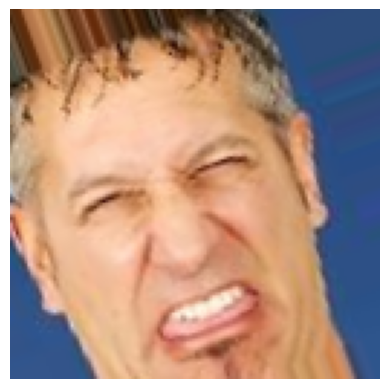

In [13]:
img = generator.flow(X_train, y_train, batch_size=20).next()

plt.imshow(img[0][0])
plt.axis("Off");
plt.show()

# AlexNet model

The model proposed in the paper is implemented using the Keras library

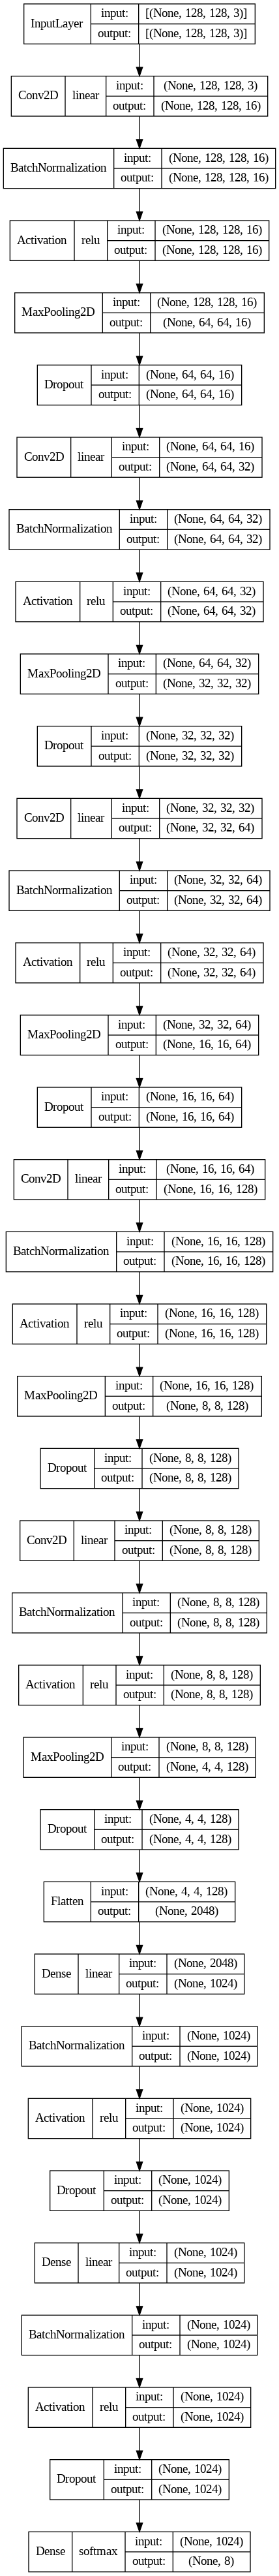

In [14]:
# Create the AlexNet variant model
AlexNet = Sequential()

# Convolution Block 1
AlexNet.add(Conv2D(16, (9, 9), input_shape=X_train[0].shape, padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2, 2)))
AlexNet.add(Dropout(0.2))

# Convolution Block 2
AlexNet.add(Conv2D(32, (7, 7), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2, 2)))
AlexNet.add(Dropout(0.2))

# Convolution Block 3
AlexNet.add(Conv2D(64, (5, 5), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2, 2)))
AlexNet.add(Dropout(0.2))

# Convolution Block 4
AlexNet.add(Conv2D(128, (3, 3), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2, 2)))
AlexNet.add(Dropout(0.2))

# Convolution Block 5
AlexNet.add(Conv2D(128, (3, 3), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2, 2)))
AlexNet.add(Dropout(0.2))

# Flatten layer
AlexNet.add(Flatten())

# Fully Connected (Dense) Layer 1
AlexNet.add(Dense(1024))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(Dropout(0.5))

# Fully Connected (Dense) Layer 2
AlexNet.add(Dense(1024))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(Dropout(0.5))

# Fully Connected (Dense) Layer 3 (Output Layer)
AlexNet.add(Dense(8, activation='softmax'))

plot_model(AlexNet, to_file='model_plot.png', show_shapes=True, show_layer_names=False, show_layer_activations=True)

With the help of ModelCheckpoint we save the model with lowest validation accuracy

In [15]:
from keras.callbacks import ModelCheckpoint

checkpoint_AlexNet = ModelCheckpoint('AlexNet/checkpoint', save_best_only=True, monitor='val_accuracy', verbose=1)

The Adam optimizer is chosen, and the hyperparameters are set according to the specifications outlined in the paper



In [16]:
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)

The loss function of categorical_crossentropy is chosen for the AlexNet model

In [17]:
AlexNet.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

The dataset is first passed into ImageDataGenerator and the enters the input layers of the model. So data_iterator is passed to the model is the training set. The number of epochs is set to 24, as specified in the paper

In [18]:
history_AlexNet = AlexNet.fit(data_iterator,epochs = 24, steps_per_epoch = steps_per_epoch, validation_data = (X_val, y_val), callbacks = [checkpoint_AlexNet], verbose = 1)

Epoch 1/24
12/12 [==============================] - ETA: 0s - loss: 2.6752 - accuracy: 0.1435
Epoch 1: val_accuracy improved from -inf to 0.12812, saving model to AlexNet/checkpoint
12/12 [==============================] - 50s 2s/step - loss: 2.6752 - accuracy: 0.1435 - val_loss: 2.0780 - val_accuracy: 0.1281
Epoch 2/24
12/12 [==============================] - ETA: 0s - loss: 2.4830 - accuracy: 0.1648
Epoch 2: val_accuracy improved from 0.12812 to 0.13000, saving model to AlexNet/checkpoint
12/12 [==============================] - 27s 2s/step - loss: 2.4830 - accuracy: 0.1648 - val_loss: 2.0752 - val_accuracy: 0.1300
Epoch 3/24
12/12 [==============================] - ETA: 0s - loss: 2.3758 - accuracy: 0.1598
Epoch 3: val_accuracy did not improve from 0.13000
12/12 [==============================] - 23s 2s/step - loss: 2.3758 - accuracy: 0.1598 - val_loss: 2.1046 - val_accuracy: 0.1300
Epoch 4/24
12/12 [==============================] - ETA: 0s - loss: 2.2632 - accuracy: 0.1733
Epoch 4

# Evaluation

The best model saved by the checkpoint is loaded and the accuracy and loss of test set is calculated on it

In [19]:
AlexNet = load_model('AlexNet/checkpoint')

loss, accuracy = AlexNet.evaluate(X_test, y_test, verbose=2)
print('\nTesting loss: %.2f, accuracy: %.2f%%'%(loss, accuracy*100))

50/50 - 1s - loss: 1.8646 - accuracy: 0.3063 - 936ms/epoch - 19ms/step

Testing loss: 1.86, accuracy: 30.63%


The training and validation loss of the AlexNet model is plotted

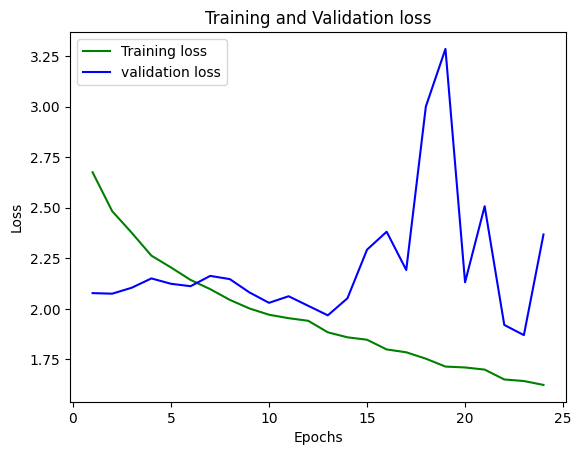

In [20]:
# Plot Training and validation loss
loss_train = history_AlexNet.history['loss']
loss_val = history_AlexNet.history['val_loss']
epochs = range(1,25)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

The training and validation accuracy of the AlexNet model is plotted

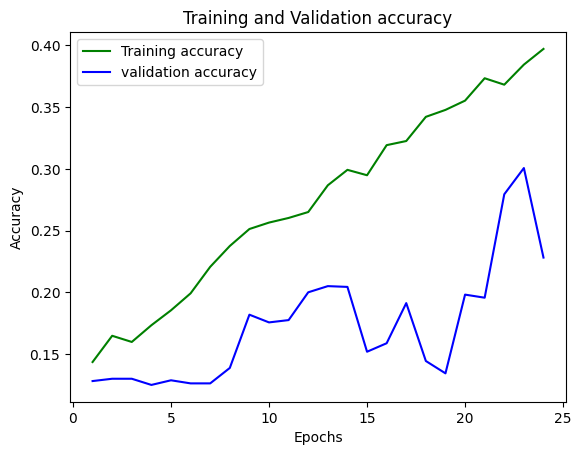

In [21]:
# Plot Training and validation accuracy
acc_train = history_AlexNet.history['accuracy']
acc_val = history_AlexNet.history['val_accuracy']
epochs = range(1,25)
plt.plot(epochs, acc_train, 'g', label='Training accuracy')
plt.plot(epochs, acc_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The Confusion Matrix of the AlexNet model is displayed

50/50 [==============================] - 1s 10ms/step


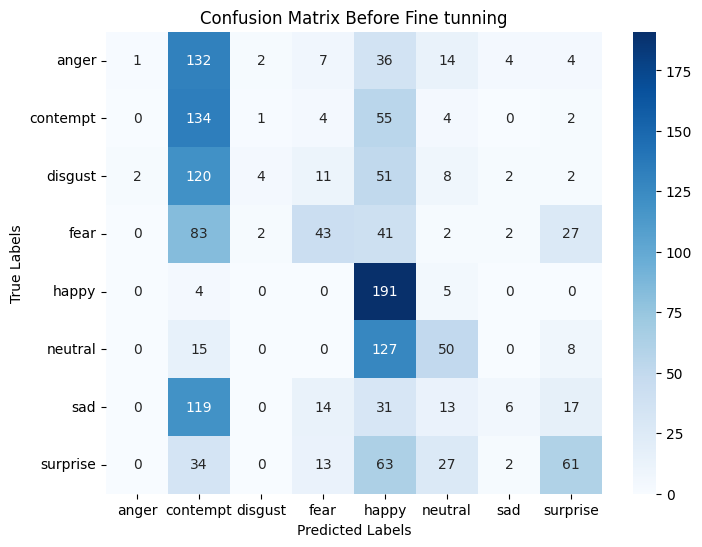

In [22]:
y_pred=AlexNet.predict(X_test)
y_pred=np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
confusion_mat = confusion_matrix(y_true, y_pred,labels=range(len(labels)))
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues',xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix Before Fine tunning')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

The classification report, which includes precision, recall, and F1 score, is presented

In [23]:
print(classification_report(y_true, y_pred,target_names=labels))

              precision    recall  f1-score   support

       anger       0.33      0.01      0.01       200
    contempt       0.21      0.67      0.32       200
     disgust       0.44      0.02      0.04       200
        fear       0.47      0.21      0.29       200
       happy       0.32      0.95      0.48       200
     neutral       0.41      0.25      0.31       200
         sad       0.38      0.03      0.06       200
    surprise       0.50      0.30      0.38       200

    accuracy                           0.31      1600
   macro avg       0.38      0.31      0.24      1600
weighted avg       0.38      0.31      0.24      1600



# Fine Tune

Initially, the best model achieved during the training phase of the AlexNet model is loaded

In [24]:
trained_model = load_model('AlexNet/checkpoint')

The model summary is displayed to provide a better view of its architecture

In [25]:
trained_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      3904      
                                                                 
 batch_normalization (Batch  (None, 128, 128, 16)      64        
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 16)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 64, 64, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        2

All the layers in the trained_model is frozen at first


In [26]:
for layer in trained_model.layers:
  layer.trainable = False

Then, the layers chosen for fine-tuning are unfrozen

In [27]:
layers_to_unfreeze = ['dense_2', 'batch_normalization_6', 'dense_1','batch_normalization_5', 'dense']  # Add the names of the layers you want to unfreeze

# Unfreeze the specified layers
for layer in trained_model.layers:
    if layer.name in layers_to_unfreeze:
        layer.trainable = True


To provide a clearer understanding of the procedure, the Trainable value of each layer is displayed, indicating which ones were chosen as trainable

In [28]:
for layer in trained_model.layers:
    print(f"Layer Name: {layer.name}, Trainable: {layer.trainable}")

Layer Name: conv2d, Trainable: False
Layer Name: batch_normalization, Trainable: False
Layer Name: activation, Trainable: False
Layer Name: max_pooling2d, Trainable: False
Layer Name: dropout, Trainable: False
Layer Name: conv2d_1, Trainable: False
Layer Name: batch_normalization_1, Trainable: False
Layer Name: activation_1, Trainable: False
Layer Name: max_pooling2d_1, Trainable: False
Layer Name: dropout_1, Trainable: False
Layer Name: conv2d_2, Trainable: False
Layer Name: batch_normalization_2, Trainable: False
Layer Name: activation_2, Trainable: False
Layer Name: max_pooling2d_2, Trainable: False
Layer Name: dropout_2, Trainable: False
Layer Name: conv2d_3, Trainable: False
Layer Name: batch_normalization_3, Trainable: False
Layer Name: activation_3, Trainable: False
Layer Name: max_pooling2d_3, Trainable: False
Layer Name: dropout_3, Trainable: False
Layer Name: conv2d_4, Trainable: False
Layer Name: batch_normalization_4, Trainable: False
Layer Name: activation_4, Trainable: Fa

With the help of ModelCheckpoint we save the model with lowest validation accuracy

In [29]:
checkpoint_tune = ModelCheckpoint('tune/checkpoint', save_best_only=True, monitor='val_accuracy', verbose=1)

The Adam optimizer is chosen, and the hyperparameters are set according to the specifications outlined in the paper

In [30]:
optimizer_tune = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)

The loss function of categorical_crossentropy is chosen for the AlexNet model

In [31]:
trained_model.compile(optimizer=optimizer_tune, loss='categorical_crossentropy', metrics=['accuracy'])

The Tune set with the validation split of 10% is passed into the model.The number of epochs is set to 24, as specified in the paper

In [32]:
history_tune = trained_model.fit(X_tune , y_tune, validation_split=0.1, epochs=24, batch_size=32, callbacks=[checkpoint_tune], verbose = 1)

Epoch 1/24
41/45 [==========================>...] - ETA: 0s - loss: 2.0936 - accuracy: 0.2934
Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to tune/checkpoint
45/45 [==============================] - 6s 88ms/step - loss: 2.0803 - accuracy: 0.2924 - val_loss: 3.1993 - val_accuracy: 0.0000e+00
Epoch 2/24
42/45 [===========================>..] - ETA: 0s - loss: 1.8305 - accuracy: 0.3289
Epoch 2: val_accuracy did not improve from 0.00000
45/45 [==============================] - 1s 19ms/step - loss: 1.8485 - accuracy: 0.3264 - val_loss: 3.2491 - val_accuracy: 0.0000e+00
Epoch 3/24
45/45 [==============================] - ETA: 0s - loss: 1.7276 - accuracy: 0.3542
Epoch 3: val_accuracy improved from 0.00000 to 0.00625, saving model to tune/checkpoint
45/45 [==============================] - 10s 232ms/step - loss: 1.7276 - accuracy: 0.3542 - val_loss: 3.0738 - val_accuracy: 0.0063
Epoch 4/24
45/45 [==============================] - ETA: 0s - loss: 1.6531 - accuracy: 0.3799


# Fine tune evaluation

The best model saved by the checkpoint is loaded and the accuracy and loss of test set is calculated on it

In [33]:
Tuned_model = load_model('tune/checkpoint')

loss, accuracy = Tuned_model.evaluate(X_test, y_test, verbose=2)
print('\nTesting loss: %.2f, accuracy: %.2f%%'%(loss, accuracy*100))

50/50 - 1s - loss: 2.2281 - accuracy: 0.3281 - 913ms/epoch - 18ms/step

Testing loss: 2.23, accuracy: 32.81%


The training and validation loss of the Fine tune model is plotted

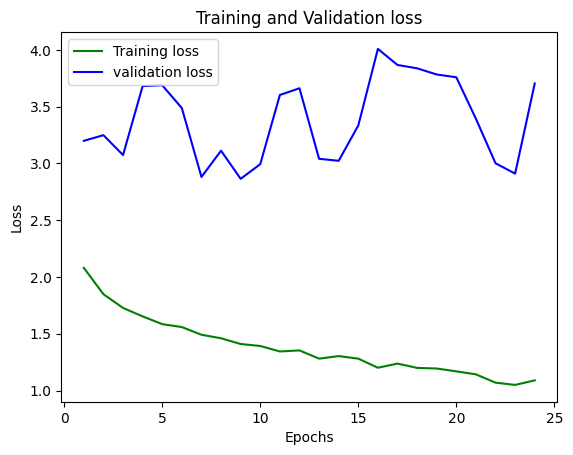

In [34]:
# Plot Training and validation loss
loss_train = history_tune.history['loss']
loss_val = history_tune.history['val_loss']
epochs = range(1,25)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

The training and validation accuracy of the Fine tune model is plotted

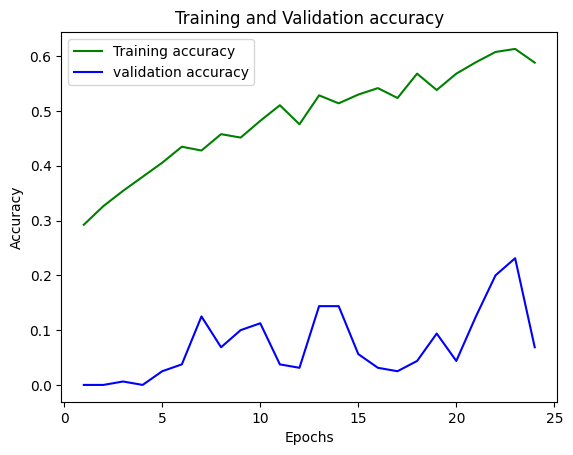

In [35]:
# Plot Training and validation accuracy
acc_train = history_tune.history['accuracy']
acc_val = history_tune.history['val_accuracy']
epochs = range(1,25)
plt.plot(epochs, acc_train, 'g', label='Training accuracy')
plt.plot(epochs, acc_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The Confusion Matrix of the AlexNet model is displayed

50/50 [==============================] - 1s 8ms/step


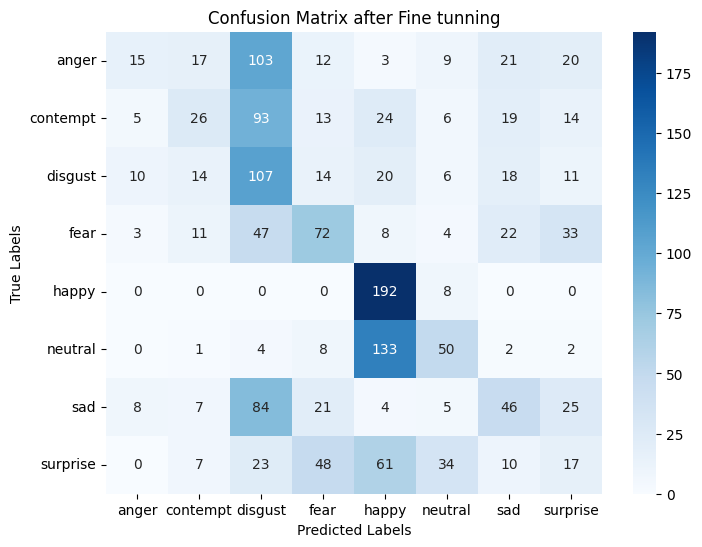

In [36]:
y_pred_tune = Tuned_model.predict(X_test)
y_pred_tune = np.argmax(y_pred_tune, axis=1)
y_true = np.argmax(y_test, axis=1)
confusion_mat = confusion_matrix(y_true, y_pred_tune,labels=range(len(labels)))
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues',xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix after Fine tunning')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

The classification report, which includes precision, recall, and F1 score, is presented

In [37]:
print(classification_report(y_true, y_pred_tune,target_names=labels))

              precision    recall  f1-score   support

       anger       0.37      0.07      0.12       200
    contempt       0.31      0.13      0.18       200
     disgust       0.23      0.54      0.32       200
        fear       0.38      0.36      0.37       200
       happy       0.43      0.96      0.60       200
     neutral       0.41      0.25      0.31       200
         sad       0.33      0.23      0.27       200
    surprise       0.14      0.09      0.11       200

    accuracy                           0.33      1600
   macro avg       0.33      0.33      0.29      1600
weighted avg       0.33      0.33      0.29      1600



# Fine Tune 2

For a more comprehensive understanding of how fine-tuning works, this operation is repeated, but this time, the convolution layers are unfrozen instead of the dense layers




In [38]:
for layer in trained_model.layers:
  layer.trainable = False

In [39]:
layers_to_unfreeze = ['conv2d_4', 'batch_normalization_4', 'conv2d_3','batch_normalization_3']  # Add the names of the layers you want to unfreeze

# Unfreeze the specified layers
for layer in trained_model.layers:
    if layer.name in layers_to_unfreeze:
        layer.trainable = True


In [40]:
for layer in trained_model.layers:
    print(f"Layer Name: {layer.name}, Trainable: {layer.trainable}")

Layer Name: conv2d, Trainable: False
Layer Name: batch_normalization, Trainable: False
Layer Name: activation, Trainable: False
Layer Name: max_pooling2d, Trainable: False
Layer Name: dropout, Trainable: False
Layer Name: conv2d_1, Trainable: False
Layer Name: batch_normalization_1, Trainable: False
Layer Name: activation_1, Trainable: False
Layer Name: max_pooling2d_1, Trainable: False
Layer Name: dropout_1, Trainable: False
Layer Name: conv2d_2, Trainable: False
Layer Name: batch_normalization_2, Trainable: False
Layer Name: activation_2, Trainable: False
Layer Name: max_pooling2d_2, Trainable: False
Layer Name: dropout_2, Trainable: False
Layer Name: conv2d_3, Trainable: True
Layer Name: batch_normalization_3, Trainable: True
Layer Name: activation_3, Trainable: False
Layer Name: max_pooling2d_3, Trainable: False
Layer Name: dropout_3, Trainable: False
Layer Name: conv2d_4, Trainable: True
Layer Name: batch_normalization_4, Trainable: True
Layer Name: activation_4, Trainable: False


In [41]:
checkpoint_tune = ModelCheckpoint('tune/checkpoint', save_best_only=True, monitor='val_accuracy', verbose=1)

In [42]:
optimizer_tune = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)

In [43]:
trained_model.compile(optimizer=optimizer_tune, loss='categorical_crossentropy', metrics=['accuracy'])

In [44]:
history_tune = trained_model.fit(X_tune , y_tune, validation_split=0.1, epochs=24, batch_size=32, callbacks=[checkpoint_tune], verbose = 1)

Epoch 1/24
44/45 [============================>.] - ETA: 0s - loss: 1.2102 - accuracy: 0.5689
Epoch 1: val_accuracy improved from -inf to 0.11250, saving model to tune/checkpoint
45/45 [==============================] - 5s 85ms/step - loss: 1.2014 - accuracy: 0.5729 - val_loss: 3.3463 - val_accuracy: 0.1125
Epoch 2/24
43/45 [===========================>..] - ETA: 0s - loss: 1.0556 - accuracy: 0.6054
Epoch 2: val_accuracy did not improve from 0.11250
45/45 [==============================] - 1s 18ms/step - loss: 1.0701 - accuracy: 0.5986 - val_loss: 4.2770 - val_accuracy: 0.0750
Epoch 3/24
44/45 [============================>.] - ETA: 0s - loss: 0.9473 - accuracy: 0.6399
Epoch 3: val_accuracy did not improve from 0.11250
45/45 [==============================] - 1s 17ms/step - loss: 0.9442 - accuracy: 0.6403 - val_loss: 4.5832 - val_accuracy: 0.0688
Epoch 4/24
44/45 [============================>.] - ETA: 0s - loss: 0.8859 - accuracy: 0.6761
Epoch 4: val_accuracy did not improve from 0.11

In [45]:
Tuned_model = load_model('tune/checkpoint')

loss, accuracy = Tuned_model.evaluate(X_test, y_test, verbose=2)
print('\nTesting loss: %.2f, accuracy: %.2f%%'%(loss, accuracy*100))

50/50 - 1s - loss: 2.6748 - accuracy: 0.3338 - 769ms/epoch - 15ms/step

Testing loss: 2.67, accuracy: 33.38%


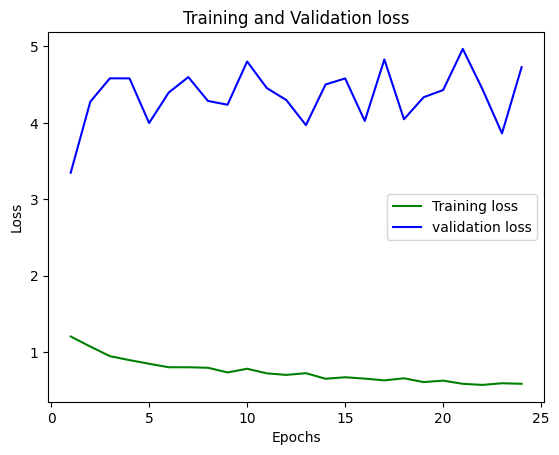

In [46]:
# Plot Training and validation loss
loss_train = history_tune.history['loss']
loss_val = history_tune.history['val_loss']
epochs = range(1,25)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

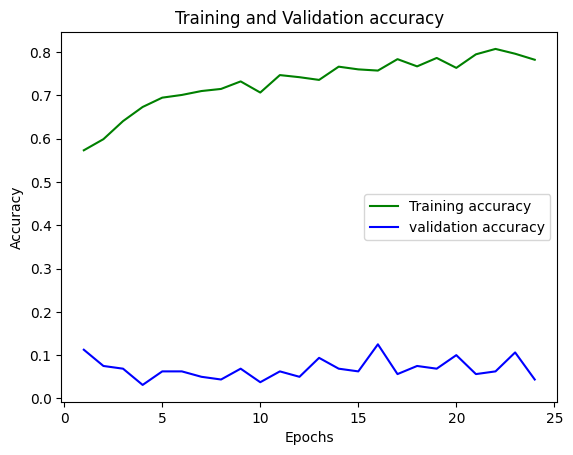

In [47]:
# Plot Training and validation accuracy
acc_train = history_tune.history['accuracy']
acc_val = history_tune.history['val_accuracy']
epochs = range(1,25)
plt.plot(epochs, acc_train, 'g', label='Training accuracy')
plt.plot(epochs, acc_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

50/50 [==============================] - 1s 9ms/step


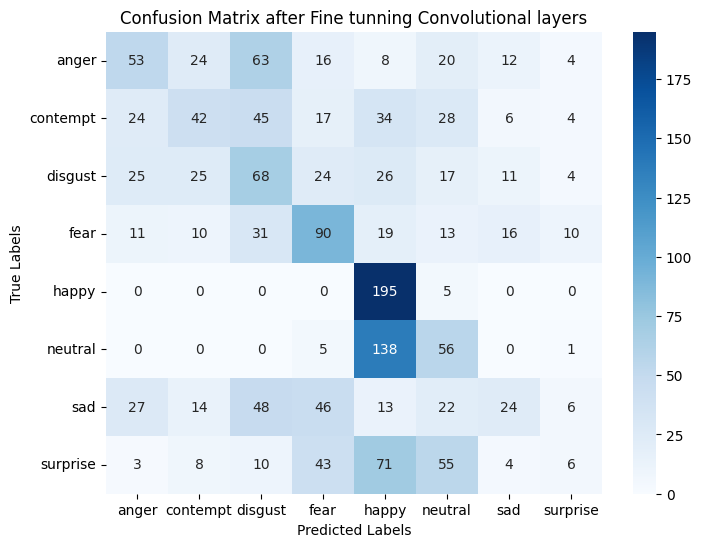

In [48]:
y_pred_tune = Tuned_model.predict(X_test)
y_pred_tune = np.argmax(y_pred_tune, axis=1)
y_true = np.argmax(y_test, axis=1)
confusion_mat = confusion_matrix(y_true, y_pred_tune,labels=range(len(labels)))
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues',xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix after Fine tunning Convolutional layers')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [49]:
print(classification_report(y_true, y_pred_tune,target_names=labels))

              precision    recall  f1-score   support

       anger       0.37      0.27      0.31       200
    contempt       0.34      0.21      0.26       200
     disgust       0.26      0.34      0.29       200
        fear       0.37      0.45      0.41       200
       happy       0.39      0.97      0.55       200
     neutral       0.26      0.28      0.27       200
         sad       0.33      0.12      0.18       200
    surprise       0.17      0.03      0.05       200

    accuracy                           0.33      1600
   macro avg       0.31      0.33      0.29      1600
weighted avg       0.31      0.33      0.29      1600



# ROC Curve

50/50 [==============================] - 0s 9ms/step


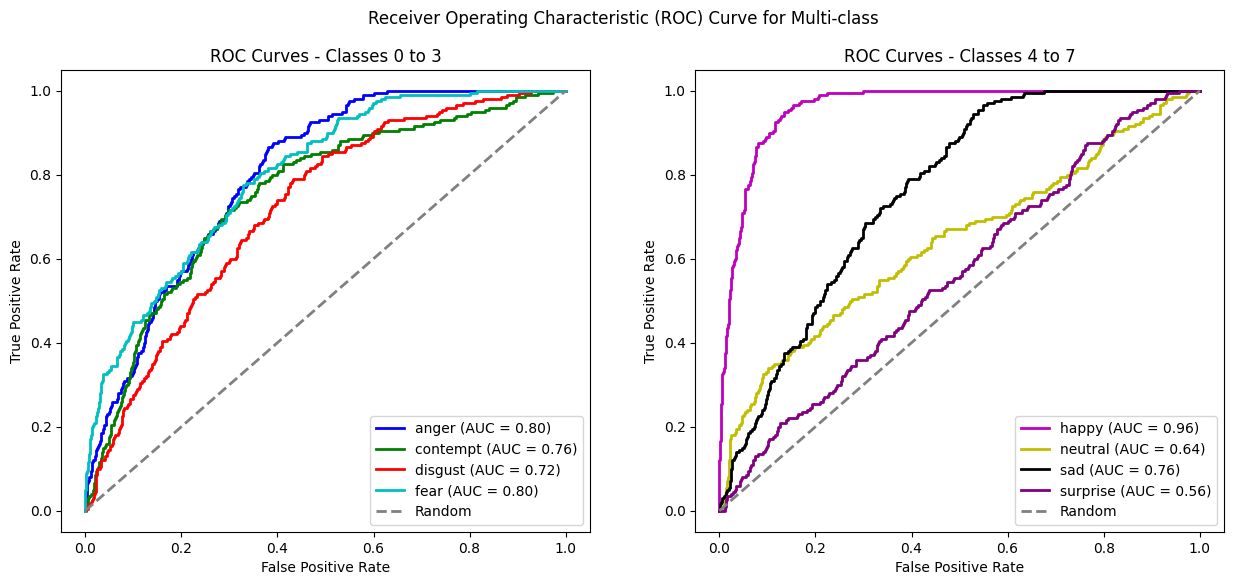

In [50]:
y_ROC = Tuned_model.predict(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()

# Replace class indices with class labels
class_labels = ['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

for i, label in enumerate(class_labels):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_ROC[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves in two subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# First subplot
axs[0].set_title('ROC Curves - Classes 0 to 3')
colors = ['b', 'g', 'r', 'c']
for i, color in zip(range(4), colors):
    axs[0].plot(fpr[i], tpr[i], color=color, lw=2, label=f'{class_labels[i]} (AUC = {roc_auc[i]:.2f})')

axs[0].plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random')
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[0].legend(loc="lower right")

# Second subplot
axs[1].set_title('ROC Curves - Classes 4 to 7')
colors = ['m', 'y', 'k', 'purple']
for i, color in zip(range(4, 8), colors):
    axs[1].plot(fpr[i], tpr[i], color=color, lw=2, label=f'{class_labels[i]} (AUC = {roc_auc[i]:.2f})')

axs[1].plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random')
axs[1].set_xlabel('False Positive Rate')
axs[1].set_ylabel('True Positive Rate')
axs[1].legend(loc="lower right")

plt.suptitle('Receiver Operating Characteristic (ROC) Curve for Multi-class')
plt.show()